In [3]:
import pandas as pd
import scipy as sc
import numpy as np
import os


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import colorConverter
import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [24]:
from constants import guest_types
from constants import colors
from constants import systems
from bootstrap import bootstrap
from bootstrap import dG_bootstrap
from bootstrap import dH_bootstrap
import plotting

# Load in results

In [26]:
bgbg = pd.read_csv("results/bgbg_tip3p_by_orientation.csv")
bgbg_combined = pd.read_csv("results/bgbg_tip3p_combined.csv")

bg2bg2 = pd.read_csv("results/bg2bg2_tip3p_by_orientation.csv")
bg2bg2_combined = pd.read_csv("results/bg2bg2_tip3p_combined.csv")

smirnoff = pd.read_csv("results/smirnoff_by_orientation.csv")
smirnoff_combined = pd.read_csv("results/smirnoff_combined.csv")

experimental = pd.read_csv("results/experimental.csv")

In [35]:
experimental.head()

,Unnamed: 0,System,Delta G,G_SEM,Delta H,H_SEM
0,0,a-bam,-1.58,0.02,-2.17,0.05
1,1,a-nmb,-1.69,0.02,-2.57,0.06
2,2,a-mba,-1.76,0.02,-2.68,0.07
3,3,a-pam,-2.72,0.00,-3.28,0.02
4,4,a-ham,-3.53,0.00,-4.19,0.02


In [48]:
bgbg["-TdS"] = bgbg["Delta G"] - bgbg["Delta H"]
bgbg["-TdS_SEM"] = np.sqrt(bgbg["G_SEM"] ** 2 + bgbg["H_SEM"] ** 2)

bg2bg2["-TdS"] = bg2bg2["Delta G"] - bg2bg2["Delta H"]
bg2bg2["-TdS_SEM"] = np.sqrt(bg2bg2["G_SEM"] ** 2 + bg2bg2["H_SEM"] ** 2)

smirnoff["-TdS"] = smirnoff["Delta G"] - smirnoff["Delta H"]
smirnoff["-TdS_SEM"] = np.sqrt(smirnoff["G_SEM"] ** 2 + smirnoff["H_SEM"] ** 2)


smirnoff_combined["-TdS"] = smirnoff_combined["Delta G"] - smirnoff_combined["Delta H"]
smirnoff_combined["-TdS_SEM"] = np.sqrt(
    smirnoff_combined["G_SEM"] ** 2 + smirnoff_combined["H_SEM"] ** 2
)

bgbg_combined["-TdS"] = bgbg_combined["Delta G"] - bgbg_combined["Delta H"]
bgbg_combined["-TdS_SEM"] = np.sqrt(
    bgbg_combined["G_SEM"] ** 2 + bgbg_combined["H_SEM"] ** 2
)

bg2bg2_combined["-TdS"] = bg2bg2_combined["Delta G"] - bg2bg2_combined["Delta H"]
bg2bg2_combined["-TdS_SEM"] = np.sqrt(
    bg2bg2_combined["G_SEM"] ** 2 + bg2bg2_combined["H_SEM"] ** 2
)

experimental["-TdS"] = experimental["Delta G"] - experimental["Delta H"]
experimental["-TdS_SEM"] = np.sqrt(
    experimental["G_SEM"] ** 2 + experimental["H_SEM"] ** 2
)


# Plot comparisons

In [49]:
def scatter(df, x, y, xerr, yerr, xlabel, ylabel, colors, name, statistics_file_prefix):
    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

    for index, typ in enumerate(df["Type"].unique()):
        tmp = df[df["Type"] == typ]        
        ax.errorbar(
            tmp[x],
            tmp[y],
            xerr=tmp[xerr],
            yerr=tmp[yerr],
            fmt="o",
            markersize=8,
            markeredgecolor="k",
            markeredgewidth=0.2,
            elinewidth=1.0,
            ecolor="0.5",
            color=colors[typ],
        )

        type_statistics = pd.read_csv(f"results/{statistics_file_prefix}_{typ}.csv")
        type_statistics.index = type_statistics["Unnamed: 0"]
        type_string = f"R$^2$ = {type_statistics['mean']['R**2']:0.2f}"
        artist = ax.annotate(
            type_string,
            (0.98, 0.02 + 0.05 * index),
            xytext=(4, -4),
            xycoords="axes fraction",
            textcoords="offset points",
            horizontalalignment="right",
            verticalalignment="bottom",
            size=14,
            color=colors[typ],
            transform=ax.transAxes,
        )

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.plot([-50, 50], [-50, 50], ls="-", c="0.3", zorder=-1, lw="0.5")
    ax.set_ylim(-8, 6)
    ax.set_xlim(-8, 6)

    statistics = pd.read_csv(f"results/{statistics_file_prefix}_overall.csv")
    statistics.index = statistics["Unnamed: 0"]
    
    text = f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['mean']['RMSE']-1.96*statistics['sem']['RMSE']:0.2f}, {statistics['mean']['RMSE']+1.96*statistics['sem']['RMSE']:0.2f}]"
    text += "\n"
    text += f"R$^2$ = {statistics['mean']['R**2']:0.2f} [{statistics['mean']['R**2']-1.96*statistics['sem']['R**2']:0.2f}, {statistics['mean']['R**2']+1.96*statistics['sem']['R**2']:0.2f}]"
    left, width = .25, .5
    bottom, height = .25, .5
    right = left + width
    top = bottom + height
    ax.annotate(
        text,
        (0.01, 0.99),
        xytext=(4, -4),
        xycoords="axes fraction",
        textcoords="offset points",
        horizontalalignment="left",
        verticalalignment="top",
        size=14,
        backgroundcolor="white",
        transform=ax.transAxes,
    )
    fig.savefig(f"figures/{name}", bbox_inches="tight")    

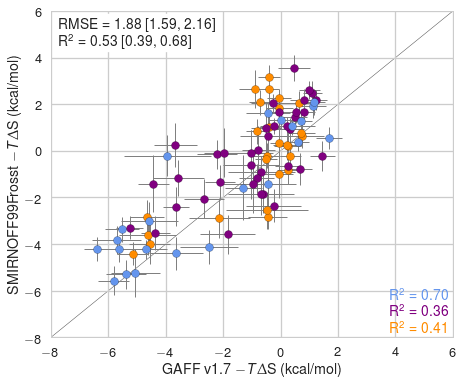

In [57]:
# SMIRNOFF99Frosst vs. GAFF v1.7

df = smirnoff.merge(bgbg, on=["System", "Type"], suffixes=("_smirnoff",
                                                                "_bgbg_tip3p"))
assert(len(df) == 86)

artist = scatter(df, 
        x="-TdS_bgbg_tip3p",
        y="-TdS_smirnoff",
        xerr="-TdS_SEM_bgbg_tip3p",
        yerr="-TdS_SEM_smirnoff",
        xlabel=r"GAFF v1.7 $-T\Delta$S (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $-T\Delta$S (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-GAFF-v1.7-TdS.pdf",
        statistics_file_prefix="bgbg_smirnoff_by_orientation_-TdS_statistics")

FileNotFoundError: File b'results/bg2bg2_smirnoff_by_orientation_TdS_statistics_aliphatic_ammoniums.csv' does not exist

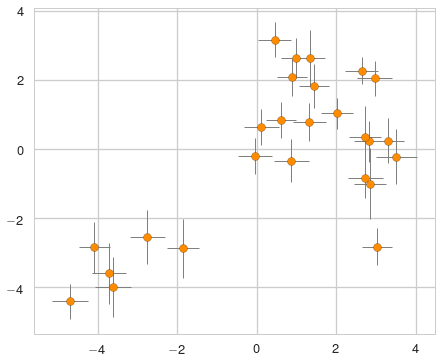

In [58]:
# SMIRNOFF99Frosst vs. GAFF v2.1

df = smirnoff.merge(bg2bg2, on=["System", "Type"], suffixes=("_smirnoff",
                                                                "_bg2bg2_tip3p"))
assert(len(df) == 86)

scatter(df, 
        x="-TdS_bg2bg2_tip3p",
        y="-TdS_smirnoff",
        xerr="-TdS_SEM_bg2bg2_tip3p",
        yerr="-TdS_SEM_smirnoff",
        xlabel=r"GAFF v2.1 $-T\Delta$S (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $-T\Delta$S (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-GAFF-v2.1-TdS.pdf",
        statistics_file_prefix="bg2bg2_smirnoff_by_orientation_TdS_statistics")

In [ ]:
# GAFF v1.7 vs. GAFF v2.1

df = bgbg.merge(bg2bg2, on=["System", "Type"], suffixes=("_bgbg_tip3p",
                                                                "_bg2bg2_tip3p"))
assert(len(df) == 86)

scatter(df, 
        x="-TdS_bgbg_tip3p",
        y="-TdS_bg2bg2_tip3p",
        xerr="-TdS_SEM_bgbg_tip3p",
        yerr="-TdS_SEM_bg2bg2_tip3p",
        xlabel=r"GAFF v1.7 $-T\Delta$S (kcal/mol)",
        ylabel=r"GAFF v2.1 $-T\Delta$S (kcal/mol)",
        colors=colors,
        name="GAFF-v2.1-vs-GAFF-v1.7-TdS.pdf",
        statistics_file_prefix="bgbg_bg2bg2_by_orientation_-TdS_statistics")

# Combined data

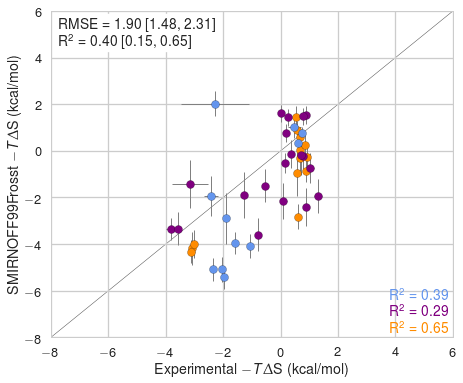

In [53]:
# SMIRNOFF99Frosst vs. Experiment

df = smirnoff_combined.merge(experimental, on=["System"], suffixes=("_smirnoff",
                                                                "_experiment"))
assert(len(df) == 43)

scatter(df, 
        x="-TdS_experiment",
        y="-TdS_smirnoff",
        xerr="-TdS_SEM_experiment",
        yerr="-TdS_SEM_smirnoff",
        xlabel=r"Experimental $-T\Delta$S (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $-T\Delta$S (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-Experiment-TdS.pdf",
        statistics_file_prefix="experimental_smirnoff_-TdS_statistics")

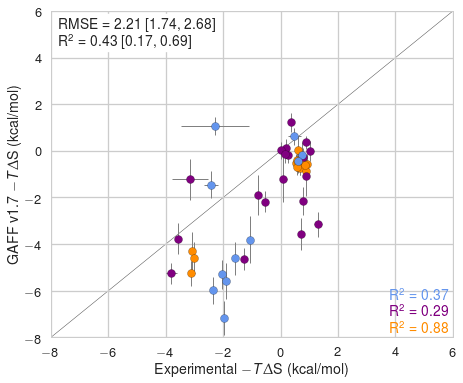

In [54]:
# GAFF v1.7 vs. Experiment

df = bgbg_combined.merge(experimental, on=["System"], suffixes=("_bgbg",
                                                                "_experiment"))
assert(len(df) == 43)

scatter(df, 
        x="-TdS_experiment",
        y="-TdS_bgbg",
        xerr="-TdS_SEM_experiment",
        yerr="-TdS_SEM_bgbg",
        xlabel=r"Experimental $-T\Delta$S (kcal/mol)",
        ylabel=r"GAFF v1.7 $-T\Delta$S (kcal/mol)",
        colors=colors,
        name="GAFF-v1.7-vs-Experiment-TdS.pdf",
        statistics_file_prefix="experimental_bgbg_-TdS_statistics")

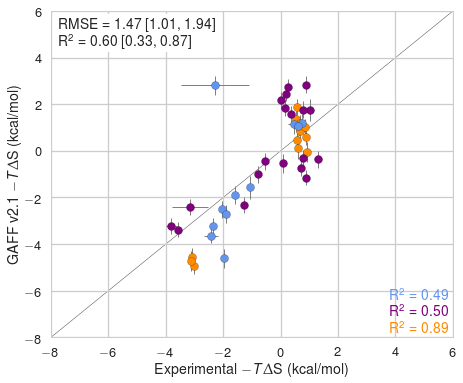

In [55]:
# GAFF v2.1 vs. Experiment

df = bg2bg2_combined.merge(experimental, on=["System"], suffixes=("_bg2bg2",
                                                                "_experiment"))
assert(len(df) == 43)

scatter(df, 
        x="-TdS_experiment",
        y="-TdS_bg2bg2",
        xerr="-TdS_SEM_experiment",
        yerr="-TdS_SEM_bg2bg2",
        xlabel=r"Experimental $-T\Delta$S (kcal/mol)",
        ylabel=r"GAFF v2.1 $-T\Delta$S (kcal/mol)",
        colors=colors,
        name="GAFF-v2.1-vs-Experiment-TdS.pdf",
        statistics_file_prefix="experimental_bg2bg2_-TdS_statistics")

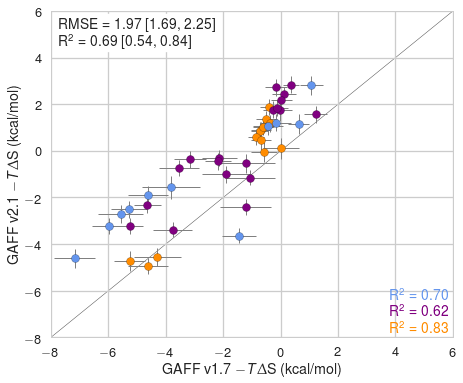

In [56]:
# GAFF v1.7 vs. GAFF v2.1

df = bg2bg2_combined.merge(bgbg_combined, on=["System", "Type"], suffixes=("_bg2bg2",
                                                                "_bgbg"))
assert(len(df) == 43)

scatter(df, 
        x="-TdS_bgbg",
        y="-TdS_bg2bg2",
        xerr="-TdS_SEM_bgbg",
        yerr="-TdS_SEM_bg2bg2",
        xlabel=r"GAFF v1.7 $-T\Delta$S (kcal/mol)",
        ylabel=r"GAFF v2.1 $-T\Delta$S (kcal/mol)",
        colors=colors,
        name="GAFF-v2.1-vs-GAFF-v1.7-combined-TdS.pdf",
        statistics_file_prefix="bgbg_bg2bg2_-TdS_statistics")